In [19]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim


In [20]:
transform = transforms.ToTensor() # define a conversão da imagem para tensor

train_set = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

val_set = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega a parte de validação do dataset
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes


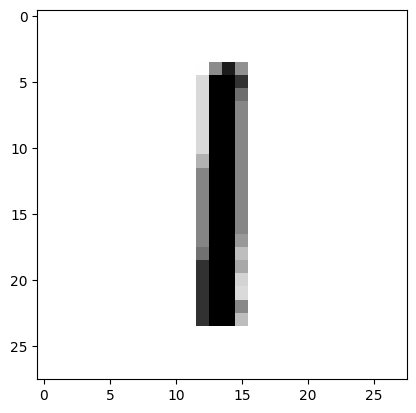

In [21]:
data_iter = iter(train_loader)
imagens, etiquetas = next(data_iter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')


In [22]:
print(imagens[0].shape) # verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [23]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10
        # para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda


In [24]:
def treino(modelo, train_loader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a política de atualização dos pesos e da bias
    inicio = time() # timer para sabermos quanto levou o treino

    criterio = nn.NLLLoss() # definindo o critério para calcular a perda
    EPOCHS = 10 # número de epochs que o algoritmo rodará
    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão

        for imagens, etiquetas in train_loader:

            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casas para ficarem compatíveis com a
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

            perda_instantanea.backward() # back propagation a partir da perda

            otimizador.step() # atualizando os pesos e as bias

            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada

        else:
            print('Epoch {} - Perda Resultante: {}'.format(epoch+1, perda_acumulada/len(train_loader)))    
    print('\ntempi de treino (em minutos) =', (time()-inicio)/60)

In [25]:
def validacao(modelo, val_loader, device):
    conta_corretas, conta_todas = 0, 0

    for imagens, etiquetas in val_loader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem alto custo de processamento

            with torch.no_grad():
                logps = modelo(img.to(device)) # output do modelo em escala logaritmica

            ps = torch.exp(logps) # converte output(tensor) para escala normal
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) # converte o tensor em número, no caso, o número que o modelo previu como correto
            etiqueta_certa = etiquetas.numpy()[1]

            if(etiqueta_certa == etiqueta_pred): # compara a previsão com o valor correto
                conta_corretas += 1
            conta_todas += 1

    print(f'Total de imagens testadas = {conta_todas}')
    print('\nPrecisão do modelo = {}%'.format(conta_corretas*100/conta_todas))

In [26]:
modelo = Modelo()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)